In [1]:
#Import required modules
import pandas as pd
import ast 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

In [2]:
#Import missing values plot function
import PlotMissing

In [3]:
#Read in data as string datatype
data = pd.read_csv('Data/Sources/qs.animals_products_20200516.txt', sep='\t', dtype = 'str')
#Create full description column
data['full_desc'] = data[['SOURCE_DESC', 'SECTOR_DESC', 'GROUP_DESC', 'COMMODITY_DESC', 'CLASS_DESC', 'PRODN_PRACTICE_DESC', 
                     'UTIL_PRACTICE_DESC', 'STATISTICCAT_DESC', 'UNIT_DESC', 'SHORT_DESC', 'DOMAIN_DESC','DOMAINCAT_DESC', 
                     'AGG_LEVEL_DESC']].agg('|'.join, axis=1)
#Create county + state column
data['county_state'] = data['COUNTY_NAME'] + ", " + data['STATE_NAME']

#Replace "(NA)" with NaN
data.loc[data['VALUE'] == "(NA)", 'VALUE'] = np.nan

In [4]:
#Define list of columns to use for merging
group_columns = ['county_state', 'STATE_NAME', 'STATE_ANSI', 'COUNTY_NAME', 'COUNTY_ANSI','YEAR', 'AGG_LEVEL_DESC']

In [5]:
# Define function to remove years before time period of interest
def years_of_interest(df, year):
    df.drop(df[df['YEAR'].astype('int') < year].index, inplace = True)

In [6]:
#Function to impute (D) withheld values in a dataframe
#Take the total acrosss the state and divide by the number of counties withheld
#Assign this value to all of the withheld counties
def impute_withdrawn(df):
    
    withheld = df[df['VALUE'] == "(D)"].groupby(['STATE_NAME', 'YEAR']).count().reset_index()[['STATE_NAME', 'YEAR', 'VALUE']]
    
    if withheld.shape[0] > 0:
    
        state_totals = df[df['AGG_LEVEL_DESC'] == 'STATE'][['STATE_NAME', 'YEAR', 'VALUE']]
        state_totals.drop(state_totals[state_totals['VALUE'] == "(D)"].index, inplace = True)
        state_totals.dropna(inplace = True)
        state_totals['VALUE'] = state_totals['VALUE'].str.replace(",","").astype('int')

        county_vals = df[(df['AGG_LEVEL_DESC'] == 'COUNTY') & (df['VALUE'] != "(D)")][['STATE_NAME', 'YEAR', 'VALUE']]
        county_vals['VALUE'] = county_vals['VALUE'].str.replace(",","").astype('int')
        county_totals = county_vals.groupby(['STATE_NAME', 'YEAR']).sum().reset_index()

        totals = pd.merge(left = state_totals,
                right = county_totals,
                how = 'left',
                left_on = ['STATE_NAME', 'YEAR'],
                right_on = ['STATE_NAME', 'YEAR'],
                suffixes = ('_state', '_counties'))

        totals['state_margin'] = (totals['VALUE_state'] - totals['VALUE_counties'])
        totals.dropna(inplace = True)
        totals.drop(totals[totals['state_margin'] <= 0].index, inplace = True)
        totals.drop(columns = ['VALUE_state', 'VALUE_counties'], inplace = True)

        impute = pd.merge(left = totals,
                right = withheld,
                how = 'inner',
                left_on = ['STATE_NAME', 'YEAR'],
                right_on = ['STATE_NAME', 'YEAR'],
                suffixes = ('_total', '_withheld'))
        impute['w_county'] = impute['state_margin'] / impute['VALUE']

        impute.drop(columns = ['state_margin', 'VALUE'], inplace = True)
        if impute.shape[0] > 0:

            for i in df[df['VALUE'] == "(D)"].index:
                if impute[(impute['STATE_NAME'] == df.loc[i, 'STATE_NAME']) & (impute['YEAR'] == df.loc[i, 'YEAR'])].shape[0] > 0:
                    impute_value = impute[(impute['STATE_NAME'] == df.loc[i, 'STATE_NAME']) & (impute['YEAR'] == df.loc[i, 'YEAR'])]['w_county'].values[0]
                else:
                    impute_value = np.nan

                df.loc[i, 'VALUE'] = impute_value

        else:
            df.loc[df['VALUE'] == "(D)", 'VALUE'] = np.nan

    df['VALUE'] = df['VALUE'].str.replace(",", "")

In [8]:
#Define function to append multiple source columns into one dataframe
def append_source_columns(source_columns): #Input sources as list of tuples
    #Dictionary to store dataframes of each source columns
    sources = {}
    for columns in source_columns:
        #Key of dictionary is tuple of source columns
        #Value of dictionary is copy of dataframe filtered to source columns
        sources[columns] = data[data['full_desc'].isin(columns)].copy()
    for value in sources.values():
        #Apply withdrawn imputation
        impute_withdrawn(value)
        #Restrict to years of interest
        years_of_interest(value, 1980)
        #Enforce float datatype on VALUE column
        value['VALUE'] = value['VALUE'].astype('float')
    #Return contcatenated dataframe where overlapping values are averaged
    #Concatenate State and County rows separately and then bring together to preserve both types of data
    combined_df = pd.concat([
    pd.DataFrame(pd.concat([value[value['AGG_LEVEL_DESC'] == 'STATE'] for value in sources.values()]).groupby(['STATE_NAME', 'STATE_ANSI', 'YEAR', 'AGG_LEVEL_DESC']).mean()['VALUE']).reset_index(),
    pd.DataFrame(pd.concat([value[value['AGG_LEVEL_DESC'] == 'COUNTY'] for value in sources.values()]).groupby(group_columns).mean()['VALUE']).reset_index()
    ])
    if combined_df.shape[0] == 0:
         print('Empty Dataframe Returned')
    else:
        return combined_df

In [9]:
# Define function to merge dataframes of different value columns
def df_merge(left_df, right_df, df_suffixes = [None, None]):
    return pd.merge(left = left_df,
                    right = right_df,
                    on = group_columns,
                    how = 'outer',
                    suffixes = df_suffixes)

In [10]:
#Define function to impute based on linear relationship with second variable
def linear_imputation(x_columns, y_columns, plotx, ploty, plott):
    
    combined_df = df_merge(append_source_columns(x_columns), append_source_columns(y_columns), ['_x', '_y'])

    model = sm.OLS(
        combined_df.dropna(subset = ['VALUE_x', 'VALUE_y'])['VALUE_y'],
        combined_df.dropna(subset = ['VALUE_x', 'VALUE_y'])[['VALUE_x']]
    ).fit()
    
    plt.figure(figsize = (7,5))
    plt.scatter(combined_df.dropna(subset = ['VALUE_x', 'VALUE_y'])[['VALUE_x']], 
                combined_df.dropna(subset = ['VALUE_x', 'VALUE_y'])['VALUE_y'],
                alpha = 0.5)
    plt.title(plott)
    plt.xlabel(plotx)
    plt.ylabel(ploty)
    plt.savefig(f"Plots/Linear Imputation/{plott}.jpg")
    plt.close()
    
    #Imupute with y value divided by coefficient
    combined_df.loc[(combined_df['VALUE_x'].isnull()) & ~ (combined_df['VALUE_y'].isnull()), 'VALUE_x'] = combined_df.loc[(combined_df['VALUE_x'].isnull()) & ~ (combined_df['VALUE_y'].isnull()), 'VALUE_y'] / model.params[0]
    combined_df.rename(columns = {'VALUE_x': 'VALUE'}, inplace = True)
    combined_df.dropna(subset = ['VALUE'], inplace = True)
    return combined_df.drop(columns = [i for i in combined_df.columns if 'x' in i]).drop(columns = [i for i in combined_df.columns if '_y' in i])

In [11]:
# Define function to impute based on stable* ratios
# *stable where contribution of county to state or state to nation has a standard deviation of less than 2% across observed years
def ratio_impute(df, natl_df):
    
    if 'STATE' not in df['AGG_LEVEL_DESC'].unique():
        print("No State Totals")
        return
    
    years_of_interest(natl_df, 1980)
    natl_values = natl_df.groupby('YEAR')['VALUE'].mean()
    
    for state_name in df['STATE_NAME'].unique():
        state_values = df[(df['STATE_NAME'] == state_name) & (df['AGG_LEVEL_DESC'] == 'STATE')].groupby("YEAR")['VALUE'].mean().sort_index()
        combined = pd.merge(state_values, natl_values, on = 'YEAR', how = 'inner')
        if (combined.shape[0] > 2) & (np.std(combined['VALUE_x'] / combined['VALUE_y']) < 0.02):
            state_ratio = np.mean(combined['VALUE_x'] / combined['VALUE_y'])
            extra_years = np.setdiff1d(natl_values.index, state_values.index)
            if len(extra_years) > 0:
                for year in extra_years:
                    new_line = df[(df['STATE_NAME'] == state_name) & (df['AGG_LEVEL_DESC'] == 'STATE')].head(1).copy()
                    new_line['YEAR'] = year
                    new_line['VALUE'] = state_ratio * natl_values[year]
                    df = pd.concat([df, new_line], ignore_index = True)

    for county_state in df['county_state'].unique():
        county_vals = df[df['county_state'] == county_state].groupby("YEAR")['VALUE'].mean().sort_index()
        if df[df['county_state'] == county_state]['STATE_NAME'].unique().shape[0] > 0:
            state_vals = df[(df['AGG_LEVEL_DESC'] == 'STATE') & (df['STATE_NAME'] == df[df['county_state'] == county_state]['STATE_NAME'].unique()[0])].groupby('YEAR')['VALUE'].mean().sort_index()
            combined = pd.merge(county_vals, state_vals, on = 'YEAR', how = 'inner')
            if (combined.shape[0] > 2) & (np.std(combined['VALUE_x'] / combined['VALUE_y']) < 0.02):
                county_ratio = np.mean(combined['VALUE_x'] / combined['VALUE_y'])
                extra_years = np.setdiff1d(state_vals.index, county_vals.index)
                if len(extra_years) > 0:
                    for year in extra_years:
                        new_line = df[(df['county_state'] == county_state) & (df['AGG_LEVEL_DESC'] == 'COUNTY')].head(1).copy()
                        new_line['YEAR'] = year
                        new_line['VALUE'] = county_ratio * state_vals[year]
                        df = pd.concat([df, new_line], ignore_index = True)
    return df

In [12]:
#Define function to perform linear time imputation of missing values
def time_impute(df):
    for county_state in df['county_state'].unique(): 
        gaps = np.setdiff1d(df['YEAR'].unique(), df.loc[df['county_state'] == county_state,'YEAR'].unique())
        if gaps.shape[0] > 0 and not(np.array_equal(np.arange(1980, 2021), gaps)):
            test = df[df['county_state'] == county_state]
            if test.shape[0] > 0:
                test = test.set_index(pd.to_datetime(test['YEAR'], format = '%Y')).sort_index()

                for i in range(1, len(gaps) + 1)[::-1]:
                    seqb = np.arange(1980, 1980 + i)
                    if np.setdiff1d(seqb, gaps).shape[0] == 0:
                        gaps = gaps[~np.isin(gaps, seqb)]
                        break

                for i in range(3, len(gaps) + 2)[::-1]: #Allow for carry-forward 2018-2020
                    seqt = np.arange(2020 - i, 2020+1)
                    if np.setdiff1d(seqt, gaps).shape[0] == 0:
                        gaps = gaps[~np.isin(gaps, seqt)]
                        break

                for year in gaps:
                    new_row = test.head(1).copy()
                    new_row['VALUE'] = np.nan
                    new_row['YEAR'] = year
                    new_row.index = [pd.to_datetime(year, format = "%Y")]
                    test = test.append(new_row)
                test.interpolate(method = 'time', inplace = True) #Interpolate gaps using time method with date index
                df = df.append(test[test['YEAR'].isin(gaps)].dropna(subset = ['VALUE']), ignore_index = True)
    return df

In [13]:
# Create dataframes for Beef Cows, Milk Cows, and All Cattle Head
cows_beef_all = append_source_columns([
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|(EXCL MILK COWS & REPL HEIFERS)|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, (EXCL MILK COWS & REPL HEIFERS) - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|(EXCL MILK COWS & REPL HEIFERS)|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, (EXCL MILK COWS & REPL HEIFERS) - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, BEEF|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, BEEF - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, BEEF|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, BEEF - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, BEEF|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, BEEF - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, BEEF|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, BEEF - INVENTORY|TOTAL|NOT SPECIFIED|STATE')
])

cows_milk_all = append_source_columns([
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, MILK|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, MILK - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, MILK|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, MILK - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, MILK|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, MILK - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, MILK|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, MILK - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, MILK|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY, AVG|HEAD|CATTLE, COWS, MILK - INVENTORY, AVG, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, MILK|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY, AVG|HEAD|CATTLE, COWS, MILK - INVENTORY, AVG, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|STATE'),
])

cows_all_all = append_source_columns([
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|INCL CALVES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, INCL CALVES - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|INCL CALVES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, INCL CALVES - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|INCL CALVES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, INCL CALVES - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|INCL CALVES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, INCL CALVES - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
])

In [16]:
#Combine dataframes to relate beef cows and milk cows to total cattle values
cows_combined = df_merge(df_merge(cows_beef_all, cows_milk_all, ['_beef', '_milk']), cows_all_all)

X = cows_combined.dropna()[['VALUE_beef', 'VALUE_milk']]
y = cows_combined.dropna()['VALUE']
model = sm.OLS(y, X).fit()

In [17]:
#Plot figure to show linear relationship between total cattle and sum of beef & milk cows
plt.figure(figsize = (7,5))
plt.scatter(X['VALUE_beef'] + X['VALUE_milk'], y, alpha = 0.5)
plt.title("Value of Cows Total vs Cows Beef + Cows Milk")
plt.xlabel("Sum of Beef & Milk Cows")
plt.ylabel("")
plt.savefig("Plots/Linear Imputation/CowsAll.jpg")
plt.close();

In [18]:
#Impute missing beef cow values where milk cows and total cows are known
#Impute missing milk cow values where beef cows and total cows are known
cows_milk_impute = cows_combined[(cows_combined['VALUE_milk'].isna()) & ~ (cows_combined['VALUE_beef'].isna()) & ~ (cows_combined['VALUE'].isna())].copy()

cows_combined.loc[(cows_combined['VALUE_milk'].isna()) & ~ (cows_combined['VALUE_beef'].isna()) & ~ (cows_combined['VALUE'].isna()),
                 'VALUE_milk'] = np.array([i if i > 0 else np.nan for i in (cows_milk_impute['VALUE'] - 2 * cows_milk_impute['VALUE_beef']) / 2])

cows_beef_impute = cows_combined[(cows_combined['VALUE_beef'].isna()) & ~ (cows_combined['VALUE_milk'].isna()) & ~ (cows_combined['VALUE'].isna())].copy()

cows_combined.loc[(cows_combined['VALUE_beef'].isna()) & ~ (cows_combined['VALUE_milk'].isna()) & ~ (cows_combined['VALUE'].isna()),
                 'VALUE_beef'] = np.array([i if i > 0 else np.nan for i in (cows_beef_impute['VALUE'] - 2 * cows_beef_impute['VALUE_milk']) / 2])

cows_beef_all = cows_combined.drop(columns = ['VALUE_milk', 'VALUE']).rename(columns = {'VALUE_beef': 'VALUE'}).dropna(subset = ['VALUE'])
cows_milk_all = cows_combined.drop(columns = ['VALUE_beef', 'VALUE']).rename(columns = {'VALUE_milk': 'VALUE'}).dropna(subset = ['VALUE'])

In [19]:
#Cows Beef
#Before Imputation
PlotMissing.data_holes("Data/Selected/cows_beef_head_total.csv", "Cows, Beef, Head, Before Imputation")
#Linear Relationship Imputation
cows_beef_all.to_csv("Data/Selected/Imputed/CowsBeefLinearImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/CowsBeefLinearImputed.csv", "Cows, Beef, Head, Linear Relationship Imputation")
#Stable Ratio Imputation
cows_beef_natl = data[data['full_desc'] == 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, BEEF|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, BEEF - INVENTORY|TOTAL|NOT SPECIFIED|NATIONAL'].copy()
cows_beef_natl['VALUE'] = cows_beef_natl['VALUE'].str.replace(",", "").astype('float')
cows_beef_all = ratio_impute(cows_beef_all, cows_beef_natl)
cows_beef_all.to_csv("Data/Selected/Imputed/CowsBeefRatioImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/CowsBeefRatioImputed.csv", "Cows, Beef, Head, Stable Ratio Imputation")
#Time Imputation
cows_beef_all = time_impute(cows_beef_all)
cows_beef_all.to_csv("Data/Selected/Imputed/CowsBeefTimeImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/CowsBeefTimeImputed.csv", "Cows, Beef, Head, Time Imputation")

/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [20]:
#Cows Milk
#Before Imputation
PlotMissing.data_holes("Data/Selected/cows_milk_head_total.csv", "Cows, Milk, Head, Before Imputation")
#Linear Relationship Imputation
cows_milk_all.to_csv("Data/Selected/Imputed/CowsMilkLinearImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/CowsMilkLinearImputed.csv", "Cows, Milk, Head, Linear Relationship Imputation")
#Stable Ratio Imputation
cows_milk_natl = data[data['full_desc'] == 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|CATTLE|COWS, MILK|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CATTLE, COWS, MILK - INVENTORY|TOTAL|NOT SPECIFIED|NATIONAL'].copy()
cows_milk_natl['VALUE'] = cows_milk_natl['VALUE'].str.replace(",", "").astype('float')
cows_milk_all = ratio_impute(cows_milk_all, cows_milk_natl)
cows_milk_all.to_csv("Data/Selected/Imputed/CowsMilkRatioImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/CowsMilkRatioImputed.csv", "Cows, Milk, Head, Stable Ratio Imputation")
#Time Imputation
cows_milk_all = time_impute(cows_milk_all)
cows_milk_all.to_csv("Data/Selected/Imputed/CowsMilkTimeImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/CowsMilkTimeImputed.csv", "Cows, Milk, Head, Time Imputation")

80611


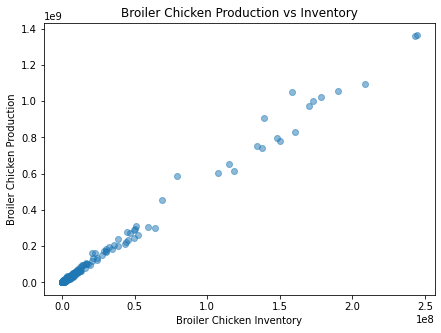

In [21]:
#Impute broiler chickens inventory using broiler chickens production
chickens_broilers = linear_imputation([('CENSUS|ANIMALS & PRODUCTS|POULTRY|CHICKENS|BROILERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, BROILERS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|POULTRY|CHICKENS|BROILERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, BROILERS - INVENTORY|TOTAL|NOT SPECIFIED|STATE')], 
                                           [('SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|BROILERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|PRODUCTION|HEAD|CHICKENS, BROILERS - PRODUCTION, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|BROILERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|PRODUCTION|HEAD|CHICKENS, BROILERS - PRODUCTION, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|STATE')],
                                           "Broiler Chicken Inventory",
                                           "Broiler Chicken Production",
                                           "Broiler Chicken Production vs Inventory")

#Engineer Broiler chickens national inventory from national production
broilers_natl_prod = pd.read_csv("Data/Sources/Broilers Chickens National Production.csv", dtype = 'str')
broilers_natl_prod['VALUE'] = broilers_natl_prod['VALUE'].astype('float')

chickens_broilers_natl = data[data['full_desc'] == 'CENSUS|ANIMALS & PRODUCTS|POULTRY|CHICKENS|BROILERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, BROILERS - INVENTORY|TOTAL|NOT SPECIFIED|NATIONAL'].copy()
chickens_broilers_natl['VALUE'] = chickens_broilers_natl['VALUE'].str.replace(",", "").astype('float')

combine = pd.merge(chickens_broilers_natl[['YEAR', 'VALUE']], broilers_natl_prod[['YEAR', 'VALUE']], on = 'YEAR', how = 'outer', suffixes = ['_inv', '_prod'])

model = sm.OLS(combine.dropna()['VALUE_prod'], combine.dropna()[['VALUE_inv']]).fit()

combine.loc[combine['VALUE_inv'].isna() & ~ combine['VALUE_prod'].isna(), 'VALUE_inv'] = combine.loc[combine['VALUE_inv'].isna() & ~ combine['VALUE_prod'].isna(), 'VALUE_prod'] / model.params[0]

chickens_broilers_natl = pd.merge(chickens_broilers_natl[['YEAR','VALUE']], combine[['YEAR', 'VALUE_inv']], on = 'YEAR', how = 'outer')

chickens_broilers_natl.loc[chickens_broilers_natl['VALUE'].isna(), 'VALUE'] = chickens_broilers_natl.loc[chickens_broilers_natl['VALUE'].isna(), 'VALUE_inv']

chickens_broilers_natl = chickens_broilers_natl[['YEAR', 'VALUE']]

#Chickens Broilers
#Before Imputation
PlotMissing.data_holes("Data/Selected/chickens_broilers_head_total.csv", "Chickens, Broilers, Head, Before Imputation")
#Linear Relationship Imputation
chickens_broilers.to_csv("Data/Selected/Imputed/ChickensBroilersLinearImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/ChickensBroilersLinearImputed.csv", "Chickens, Broilers, Head, Linear Relationship Imputation")
#Stable Ratio Imputation
chickens_broilers = ratio_impute(chickens_broilers, chickens_broilers_natl)
chickens_broilers.to_csv("Data/Selected/Imputed/ChickensBroilersRatioImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/ChickensBroilersRatioImputed.csv", "Chickens, Broilers, Stable Ratio Imputation")
#Time Ratio Imputation
chickens_broilers = time_impute(chickens_broilers)
chickens_broilers.to_csv("Data/Selected/Imputed/ChickensBroilersTimeImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/ChickensBroilersTimeImputed.csv", "Chickens, Broilers, Time Imputation")

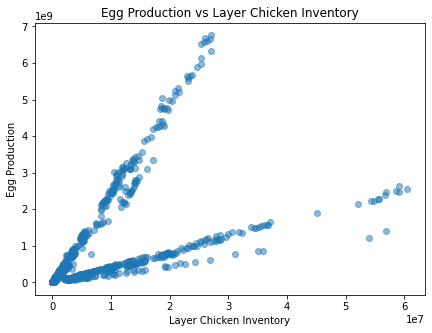

In [24]:
#Impute layer chickens inventory using egg production
chickens_layers = linear_imputation([
    ('SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|(EXCL BROILERS)|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, (EXCL BROILERS) - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|(EXCL BROILERS)|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, (EXCL BROILERS) - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY, AVG|HEAD|CHICKENS, LAYERS - INVENTORY, AVG, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY, AVG|HEAD|CHICKENS, LAYERS - INVENTORY, AVG, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|STATE'),
    ('SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, LAYERS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, LAYERS - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, LAYERS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, LAYERS - INVENTORY|TOTAL|NOT SPECIFIED|STATE')
], 
    [
        ('SURVEY|ANIMALS & PRODUCTS|POULTRY|EGGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|PRODUCTION|EGGS|EGGS - PRODUCTION, MEASURED IN EGGS|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|POULTRY|EGGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|PRODUCTION|EGGS|EGGS - PRODUCTION, MEASURED IN EGGS|TOTAL|NOT SPECIFIED|STATE')
    ],
    "Layer Chicken Inventory",
    "Egg Production",
    "Egg Production vs Layer Chicken Inventory")

chickens_layers_natl = data[data['full_desc'] == 'CENSUS|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, LAYERS - INVENTORY|TOTAL|NOT SPECIFIED|NATIONAL'].copy()
chickens_layers_natl['VALUE'] = chickens_layers_natl['VALUE'].str.replace(",", "").astype('float')

#Engineer Layer chickens national inventory from national egg production
eggs_natl_prod = pd.read_csv("Data/Sources/Eggs National Production.csv", dtype = 'str')
eggs_natl_prod['VALUE'] = eggs_natl_prod['VALUE'].astype('float')

chickens_layers_natl = data[data['full_desc'] == 'CENSUS|ANIMALS & PRODUCTS|POULTRY|CHICKENS|LAYERS|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|CHICKENS, LAYERS - INVENTORY|TOTAL|NOT SPECIFIED|NATIONAL'].copy()
chickens_layers_natl['VALUE'] = chickens_layers_natl['VALUE'].str.replace(",", "").astype('float')

combine = pd.merge(chickens_layers_natl[['YEAR', 'VALUE']], eggs_natl_prod[['YEAR', 'VALUE']], on = 'YEAR', how = 'outer', suffixes = ['_inv', '_prod'])

model = sm.OLS(combine.dropna()['VALUE_prod'], combine.dropna()[['VALUE_inv']]).fit()

combine.loc[combine['VALUE_inv'].isna() & ~ combine['VALUE_prod'].isna(), 'VALUE_inv'] = combine.loc[combine['VALUE_inv'].isna() & ~ combine['VALUE_prod'].isna(), 'VALUE_prod'] / model.params[0]

chickens_layers_natl = pd.merge(chickens_layers_natl[['YEAR','VALUE']], combine[['YEAR', 'VALUE_inv']], on = 'YEAR', how = 'outer')

chickens_layers_natl.loc[chickens_layers_natl['VALUE'].isna(), 'VALUE'] = chickens_layers_natl.loc[chickens_layers_natl['VALUE'].isna(), 'VALUE_inv']

chickens_layers_natl = chickens_layers_natl[['YEAR', 'VALUE']]

#Chickens Layers
#Before Imputation
PlotMissing.data_holes("Data/Selected/chickens_layers_head_total.csv", "Chickens, Layers, Head, Before Imputation")
#Linear Relationship Imputation
chickens_layers.to_csv("Data/Selected/Imputed/ChickensLayersLinearImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/ChickensLayersLinearImputed.csv", "Chickens, Layers, Head, Linear Relationship Imputation")
#Stable Ratio Imputation
chickens_layers = ratio_impute(chickens_layers, chickens_layers_natl)
chickens_layers.to_csv("Data/Selected/Imputed/ChickensLayersRatioImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/ChickensLayersRatioImputed.csv", "Chickens, Layers, Head, Stable Ratio Imputation")
#Time Imputation
chickens_layers = time_impute(chickens_layers)
chickens_layers.to_csv("Data/Selected/Imputed/ChickensLayersTimeImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/ChickensLayersTimeImputed.csv", "Chickens, Layers, Head, Time Imputation")

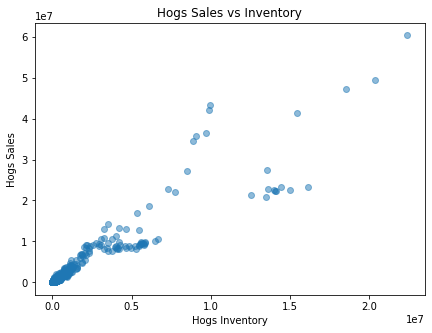

In [28]:
#Impute hog inventory using hog sales
hogs_inv_sales = linear_imputation([
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|STATE')
],
    [
        ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|SALES|HEAD|HOGS - SALES, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|SALES|HEAD|HOGS - SALES, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|STATE'),
        ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|SALES|HEAD|HOGS - SALES, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|SALES|HEAD|HOGS - SALES, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|STATE')
   ],
    "Hogs Inventory",
    "Hogs Sales",
    "Hogs Sales vs Inventory")

#Impute hog inventory using breeding hog inventory
hogs_inv_breeding = linear_imputation([
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|STATE')
],
    [
        ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|BREEDING|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS, BREEDING - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|BREEDING|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS, BREEDING - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
       
    ],
    "Hogs Inventory",
    "Hogs Breeding Inventory",
    "Hogs Breeding Inventory vs Inventory")

#Impute hog inventory using hog pig crop
hogs_inv_pigcrop = linear_imputation([
    ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|STATE'),
    ('CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|COUNTY', 'CENSUS|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|STATE')
],
    [
        ('SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|PIG CROP|HEAD|HOGS - PIG CROP, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|COUNTY', 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|PIG CROP|HEAD|HOGS - PIG CROP, MEASURED IN HEAD|TOTAL|NOT SPECIFIED|STATE'),
       
    ],
    "Hogs Inventory",
    "Hogs Pig Crop",
    "Hogs Pig Crop vs Inventory")

#Combine all imputed hog inventory into single dataframe
hogs_all_combined = pd.concat([
    pd.DataFrame(pd.concat([hogs_inv_sales[hogs_inv_sales['AGG_LEVEL_DESC'] =='STATE'], hogs_inv_breeding[hogs_inv_breeding['AGG_LEVEL_DESC'] =='STATE'], hogs_inv_pigcrop[hogs_inv_pigcrop['AGG_LEVEL_DESC'] =='STATE']]).groupby(['STATE_NAME', 'STATE_ANSI', 'YEAR', 'AGG_LEVEL_DESC']).mean()['VALUE']).reset_index(),
    pd.DataFrame(pd.concat([hogs_inv_sales, hogs_inv_breeding, hogs_inv_pigcrop]).groupby(group_columns).mean()['VALUE']).reset_index()
])

#Hogs
#Before Imputation
PlotMissing.data_holes("Data/Selected/hogs_head_total.csv", "Hogs, Head, Before Imputation")
#Linear Relationship Imputation
hogs_all_combined.to_csv("Data/Selected/Imputed/HogsLinearImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/HogsLinearImputed.csv", "Hogs, Head, Linear Relationship Imputation")
#Stable Ratio Imputation
hogs_natl = data[data['full_desc'] == 'SURVEY|ANIMALS & PRODUCTS|LIVESTOCK|HOGS|ALL CLASSES|ALL PRODUCTION PRACTICES|ALL UTILIZATION PRACTICES|INVENTORY|HEAD|HOGS - INVENTORY|TOTAL|NOT SPECIFIED|NATIONAL'].copy()
hogs_natl['VALUE'] = hogs_natl['VALUE'].str.replace(",", "").astype('float')
hogs_all_combined = ratio_impute(hogs_all_combined, hogs_natl)
hogs_all_combined.to_csv("Data/Selected/Imputed/HogsRatioImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/HogsRatioImputed.csv", "Hogs, Head, Stable Ratio Imputation")
#Time Imputation
hogs_all_combined = time_impute(hogs_all_combined)
hogs_all_combined.to_csv("Data/Selected/Imputed/HogsTimeImputed.csv")
PlotMissing.data_holes("Data/Selected/Imputed/HogsTimeImputed.csv", "Hogs, Head Time Imputation")

In [ ]:
#Dictionary of full descriptions to create csvs
columns_dict = {}
with open("Data/ColumnsDict.txt") as f:
    for line in f:
        (key,value) = line.split("::")
        columns_dict[key.replace("'", "")] = ast.literal_eval(value.strip())

#Create dataframe and csv for every item in the columns dict
#Impute dataframe VALUES with above function
for key, value in columns_dict.items():
    selected = data[data['full_desc'].isin(value)].copy()
    years_of_interest(selected, 1980)
    impute_withdrawn(selected)
    selected.to_csv(f'Data/Selected/{key}.csv', index = False)

In [ ]:
#Generate examples of stable and unstable counties for plotting
stables = {
}

unstables = {
}

df = cows_combined.drop(columns = ['VALUE_milk', 'VALUE']).rename(columns = {'VALUE_beef': 'VALUE'}).dropna(subset = ['VALUE'])

for county_state in df['county_state'].unique():
    county_vals = df[df['county_state'] == county_state].groupby("YEAR")['VALUE'].mean().sort_index()
    if df[df['county_state'] == county_state]['STATE_NAME'].unique().shape[0] > 0:
        state_vals = df[(df['AGG_LEVEL_DESC'] == 'STATE') & (df['STATE_NAME'] == df[df['county_state'] == county_state]['STATE_NAME'].unique()[0])].groupby('YEAR')['VALUE'].mean().sort_index()
        combined = pd.merge(county_vals, state_vals, on = 'YEAR', how = 'inner')
        if (combined.shape[0] > 2):
            if (np.std(combined['VALUE_x'] / combined['VALUE_y']) < 0.02):
                stables[county_state] = (combined['VALUE_x'] / combined['VALUE_y']).sort_index()
            else:
                unstables[county_state] = (combined['VALUE_x'] / combined['VALUE_y']).sort_index()

#Plot Example of Stable Counties
plt.figure(figsize = (10, 7))
plt.title("Stable County to State Ratios", fontsize = 18)
i = 0
for key, value in stables.items():
    if i < 7:
        plt.scatter(value.index, value.values, label = key)
    i+=1
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0, 0.5)
plt.xlabel("Year")
plt.ylabel("County Contribution to State")
plt.tight_layout()
plt.savefig("Plots/StableCounties.jpg")
plt.close()

#Plot Example of Stable Counties
plt.figure(figsize = (10, 7))
plt.title("Unstable County to State Ratios", fontsize = 18)
i = 0
for key, value in unstables.items():
    if i < 7:
        plt.scatter(value.index, value.values, label = key)
    i+=1
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0, 0.5)
plt.xlabel("Year")
plt.ylabel("County Contribution to State")
plt.tight_layout()
plt.savefig("Plots/UnstableCounties.jpg")
plt.close()